# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os
from tqdm.notebook import tqdm

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

In [5]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import MiniBatchDictionaryLearning, FastICA

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances

In [7]:
import warnings
warnings.filterwarnings('ignore')

## Seed

In [8]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [9]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [12]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [13]:
dynmom = preprocessing(df,
                       used=['mvol_t_1', 'mvol_t_2', 'mvol_t_3', 'mvol_t_4' , 'mvol_t_5', 'mvol_t_6',
                             'cum_winner_t_2_4', 'cum_winner_t_5_8', 'cum_winner_t_9_12',
                             'cum_loser_t_2_4', 'cum_loser_t_5_8', 'cum_loser_t_9_12'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : mvol_t_1, mvol_t_2, mvol_t_3, mvol_t_4, mvol_t_5, mvol_t_6, cum_winner_t_2_4, cum_winner_t_5_8, cum_winner_t_9_12, cum_loser_t_2_4, cum_loser_t_5_8, cum_loser_t_9_12, wml


# Modeling

In [14]:
def define_pos_wml(df, purpose):

  if purpose == 'train':
    cond_wml = (df['wml']>=0.0)
    df.loc[cond_wml, 'pos_wml'] = 0
    df.loc[~cond_wml, 'pos_wml'] = 1

  if purpose == 'test':
    cond_wml = (df['wml']>=0.0)
    df.loc[cond_wml, 'pos_wml'] = 0
    df.loc[~cond_wml, 'pos_wml'] = 1


  return df

In [52]:
def anomaly_score(x):
  score = 1/np.exp(x)
  return score

In [65]:
def Roling_Windows(data, window_size, method, model, thr):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
      'TRAIN_START_DATE':[], # 훈련 데이터 시작 지점
      'TRAIN_END_DATE':[], # 훈련 데이터 마지막 지점
      'TEST_DATE':[], # 테스트 데이터 지점
      'wml':[], # wml 값
      'dynamic_momentum':[], # 다이나믹 모멘텀 값
      'dynamic_leverage':[], # 추론된 Target 확률값
      'anomaly_score':[],
      'Actual_POS_WML':[], # 실제 Target 값 (0 or 1)
      'static_leverage':[], # 추론된 Target 값 (0 or 1)
                }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break

    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]
      TRAIN = define_pos_wml(train, purpose='train')
      TRAIN = TRAIN.loc[TRAIN['pos_wml']==0] # 비지도 학습 : 주석 처리하고 모델 학습 시 label 입력하지 않을 것

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
      TRAIN = define_pos_wml(train, purpose='train')
      TRAIN = TRAIN.loc[TRAIN['pos_wml']==0] # 비지도 학습 : 주석 처리하고 모델 학습 시 label 입력하지 않을 것

    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]
    TEST = define_pos_wml(test, purpose='test')

    # Features와 Target 구분
    X_train = TRAIN.drop(columns=['pos_wml', 'wml'])
    y_train = TRAIN['pos_wml']

    X_test = TEST.drop(columns=['pos_wml', 'wml'])
    y_test = TEST['pos_wml']

    wml_test = list(test['wml'])

    # 모델 학습 및 추론
    MODEL.fit(X_train)

    #MODEL.fit(X_train) # 비지도 학습 시 사용
    X_test_PCA = MODEL.transform(X_test)
    X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

    X_test_PCA_inverse = MODEL.inverse_transform(X_test_PCA)
    X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse,
                                      index=X_test.index)

    prob_test = cosine_similarity(X_test, X_test_PCA_inverse)
    prob_test = prob_test[0][0]

    if prob_test >= thr:
      pred_test = 0
    else:
      pred_test = 1

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(str(test.index[0]))

    result_dict['wml'].append(wml_test[0])

    dynamic_momentum = prob_test * wml_test[0]
    result_dict['dynamic_momentum'].append(dynamic_momentum)

    result_dict['Actual_POS_WML'].append(int(list(y_test)[0]))
    result_dict['static_leverage'].append(pred_test)
    result_dict['dynamic_leverage'].append(prob_test)
    result_dict['anomaly_score'].append(prob_test)

  result = pd.DataFrame(result_dict)
  result = result.set_index('TEST_DATE')

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

# Inference

In [66]:
def cum_return_sharpe_ratio(data, dynamic=True):

  if dynamic == True:
    weight = 'dynamic_leverage'
  else:
    weight = 'static_leverage'

  # 머신러닝 적용되지 않은 경우 Sharpe Ratio
  w_S = (data['wml'].mean()/data['wml'].std()) * math.sqrt(12)
  print('ORG Sharpe Ratio : {}'.format(w_S))

  # 머신러닝 적용된 경우 Sharpe Ratio
  S = (data['dynamic_momentum'].mean()/data['dynamic_momentum'].std())*math.sqrt(12)
  print('ML Sharpe Ratio : {}\n'.format(S))

  # 머신러닝 적용된 경우 누적 수익률
  data['cum_return'] = (1 + data.dynamic_momentum).cumprod() - 1

  print('\n최근 누적 수익률\n')
  latly_10 = data[['cum_return']].sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = data[['cum_return']].sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  # 머신러닝 적용되지 않은 경우 누적 수익률
  without_machine = pd.DataFrame(data['wml'])
  without_machine['wml'] = (1 + without_machine.wml).cumprod() - 1
  without_machine.columns = ['cum_return']

  # 머신러닝 여부에 따른 누적 수익률 비교
  plt.figure(figsize=(13, 6))
  plt.title('Comparing Cumulative Returns with and without Machine Learning')
  sns.lineplot(data=data, x=data.index, y=data['cum_return'], label='With_ML', color='darkgreen', lw=3)
  sns.lineplot(data=without_machine, x=without_machine.index, y=without_machine['cum_return'], label='Original', color='gray', lw=3)
  plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)

  plt.show()

In [67]:
def statistic_information(data, col):
  statistic = data[[col]].describe().T
  statistic['var'] = data[col].var()
  statistic['1%'] = data[col].quantile(0.01)
  statistic['99%'] = data[col].quantile(0.99)

  statistic = statistic[['count', 'mean', 'var', 'std',
                         'min', '1%', '25%', '50%',
                         '75%',  '99%', 'max']]

  return statistic

In [68]:
def plot_predict_result(data):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data['static_leverage']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data['static_leverage'])
  precision = precision_score(data['Actual_POS_WML'], data['static_leverage'])
  recall = recall_score(data['Actual_POS_WML'], data['static_leverage'])
  F1_score = f1_score(data['Actual_POS_WML'], data['static_leverage'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')

  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data['static_leverage'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title(f'Confusion Matrix')

  plt.show()

  # ACTUAL = PRED = 1
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 1\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = PRED = 1')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = PRED = 0
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = PRED = 0\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = PRED = 0')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 0 & PRED = 1
  cond = (data['Actual_POS_WML'] == 0) & (data['static_leverage'] == 1)
  cond_data = data.loc[cond]
  print('\nACTUAL = 0 &  PRED = 1\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = 0 & PRED = 1')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

  print()
  print('-'*80)
  print()

  # ACTUAL = 1 & PRED = 0
  cond = (data['Actual_POS_WML'] == 1) & (data['static_leverage'] == 0)
  cond_data = data.loc[cond]
  print('\nACTUAL = 1 &  PRED = 0\n')
  plt.figure(figsize=(15, 5))
  plt.title('WML & Dynamic Leverage in ACTUAL = 1 & PRED = 0')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='wml',
              label='wml')
  sns.lineplot(data=cond_data,
              x=cond_data.index,
              y='dynamic_leverage',
              label='dynamic_leverage')
  plt.xticks([cond_data.index[i] for i in range(0,len(cond_data.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  plt.show()
  info = statistic_information(cond_data, 'wml')
  display(info)
  info = statistic_information(cond_data, 'dynamic_leverage')
  display(info)

In [69]:
def plot_dynamic_momentum(data):

  print('\nTop 5 dyn_mom\n')
  display(data.sort_values(by='dynamic_momentum', ascending=False).head(5))

  print('\nBottom 5 dyn_mom\n')
  display(data.sort_values(by='dynamic_momentum', ascending=True).head(5))
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Dynamic Momentum')
  sns.histplot(data=data, x='dynamic_momentum', kde=True)
  plt.show()
  print()

  info = statistic_information(data, 'dynamic_momentum')
  display(info)
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Dynamic Leverage')
  sns.histplot(data=data, x='dynamic_leverage', kde=True)
  plt.show()
  print()

  info = statistic_information(data, 'dynamic_leverage')
  display(info)
  print()

  plt.figure(figsize=(13,8))
  plt.title('Histogram of Anomaly Score')
  sns.histplot(data=data, x='anomaly_score', kde=True)
  plt.show()
  print()

  info = statistic_information(data, 'anomaly_score')
  display(info)
  print()

  plt.figure(figsize=(15, 5))
  plt.title('Line Plot of Dynamic Momentum')
  sns.lineplot(data=data, x=data.index, y='dynamic_momentum', marker='o', markersize=0.5 ,linewidth=2)
  plt.xticks([data.index[i] for i in range(0, len(data.index), 36)],
             labels=[data.index[i][:4] for i in range(0, len(data.index), 36)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=13,
                  width=5)
  plt.show()
  print()

  plt.figure(figsize=(15, 5))
  plt.title('Dynamic Leverage vs. WML')
  sns.lineplot(data=data, x=data.index, y='wml', label='WML',linewidth=0.5, color='orange')
  sns.lineplot(data=data, x=data.index, y='dynamic_leverage', label='Dynamic Leverage' ,linewidth=0.5, color='green')

  plt.xticks([data.index[i] for i in range(0, len(data.index), 36)],
             labels=[data.index[i][:4] for i in range(0, len(data.index), 36)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=10,
                  width=5)
  plt.legend()
  plt.show()

## PCA

In [70]:
PCA_Param={'n_components':1,
           'whiten':True,
           'random_state':42}
PCA_MODEL = PCA(**PCA_Param)

In [71]:
Fixed_PCA_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=PCA_MODEL,
                                  thr=0.50)

  0%|          | 0/906 [00:00<?, ?it/s]

In [72]:
Fixed_PCA_Result.head(10)

,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,dynamic_leverage,anomaly_score,Actual_POS_WML,static_leverage
TEST_DATE,,,,,,,,
19470731,19270730,19470630,-0.052114,-0.019848,0.380860,0.380860,1,1
19470829,19270831,19470731,0.030634,0.012903,0.421191,0.421191,0,1
19470930,19270930,19470829,-0.038537,-0.020630,0.535331,0.535331,1,0
19471031,19271031,19470930,0.044931,0.037878,0.843025,0.843025,0,0
19471129,19271130,19471031,0.053920,0.048016,0.890499,0.890499,0,0
19471231,19271231,19471129,0.057494,0.055229,0.960600,0.960600,0,0
19480131,19280131,19471231,-0.045630,-0.039666,0.869289,0.869289,1,0
19480228,19280229,19480131,0.044267,0.034214,0.772908,0.772908,0,0
19480331,19280331,19480228,-0.018584,-0.015796,0.849931,0.849931,1,0


In [73]:
Fixed_PCA_Result[['anomaly_score']].describe()

,anomaly_score
count,906.000000
mean,0.894064
std,0.094096
min,0.207523
25%,0.863592
50%,0.921256
75%,0.957729
max,0.998442


In [74]:
Fixed_PCA_Result.loc[Fixed_PCA_Result['static_leverage']==0]

,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,dynamic_leverage,anomaly_score,Actual_POS_WML,static_leverage
TEST_DATE,,,,,,,,
19470930,19270930,19470829,-0.038537,-0.020630,0.535331,0.535331,1,0
19471031,19271031,19470930,0.044931,0.037878,0.843025,0.843025,0,0
19471129,19271130,19471031,0.053920,0.048016,0.890499,0.890499,0,0
19471231,19271231,19471129,0.057494,0.055229,0.960600,0.960600,0,0
19480131,19280131,19471231,-0.045630,-0.039666,0.869289,0.869289,1,0
...,...,...,...,...,...,...,...,...
20220831,20020830,20220729,-0.021856,-0.019317,0.883843,0.883843,1,0
20220930,20020930,20220831,0.099930,0.091980,0.920447,0.920447,0,0
20221031,20021031,20220930,0.129322,0.118746,0.918225,0.918225,0,0


In [75]:
Fixed_PCA_Result.loc[Fixed_PCA_Result['static_leverage']==1]

,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,dynamic_leverage,anomaly_score,Actual_POS_WML,static_leverage
TEST_DATE,,,,,,,,
19470731,19270730,19470630,-0.052114,-0.019848,0.380860,0.380860,1,1
19470829,19270831,19470731,0.030634,0.012903,0.421191,0.421191,0,1
20090731,19890731,20090630,-0.070753,-0.014683,0.207523,0.207523,1,1
20091130,19891130,20091030,0.047411,0.020180,0.425646,0.425646,0,1


ORG Sharpe Ratio : 0.7293406994683723
ML Sharpe Ratio : 0.7645507729006024


최근 누적 수익률

  2022년-12월 -> 82553.31
  2022년-11월 -> 75150.92
  2022년-10월 -> 71866.29
  2022년-09월 -> 64238.13
  2022년-08월 -> 58827.11

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 82553.31
  2등 : 2009년-02월 -> 78015.88
  3등 : 2002년-09월 -> 76684.37
  4등 : 2022년-11월 -> 75150.92
  5등 : 2022년-10월 -> 71866.29
  6등 : 2009년-01월 -> 71211.84
  7등 : 2008년-11월 -> 71049.92
  8등 : 2008년-12월 -> 69684.98
  9등 : 2002년-07월 -> 68401.46
  10등 : 2002년-08월 -> 66554.39



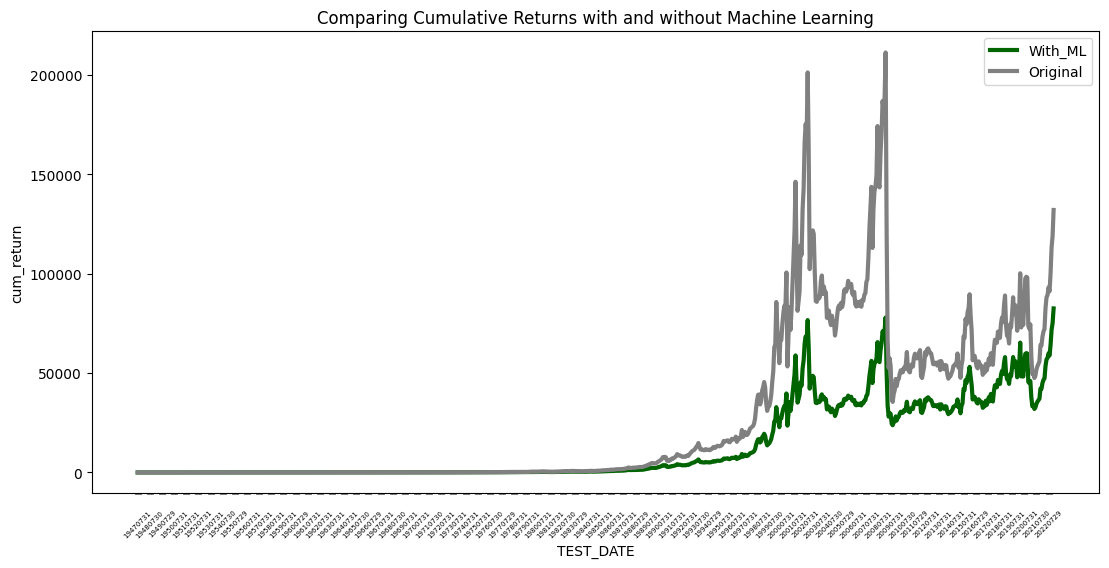

In [76]:
cum_return_sharpe_ratio(data=Fixed_PCA_Result,
                        dynamic=True)


Performance results of the model

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       590
           1       0.50      0.01      0.01       316

    accuracy                           0.65       906
   macro avg       0.58      0.50      0.40       906
weighted avg       0.60      0.65      0.52       906


accuracy : 0.6512141280353201

precision : 0.5

recall : 0.006329113924050633

F1-Score : 0.012499999999999999



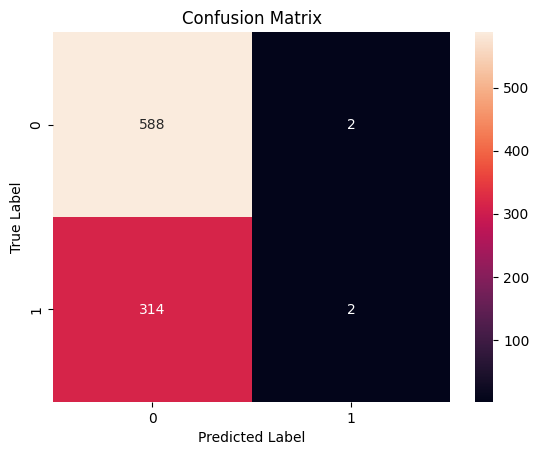


ACTUAL = PRED = 1



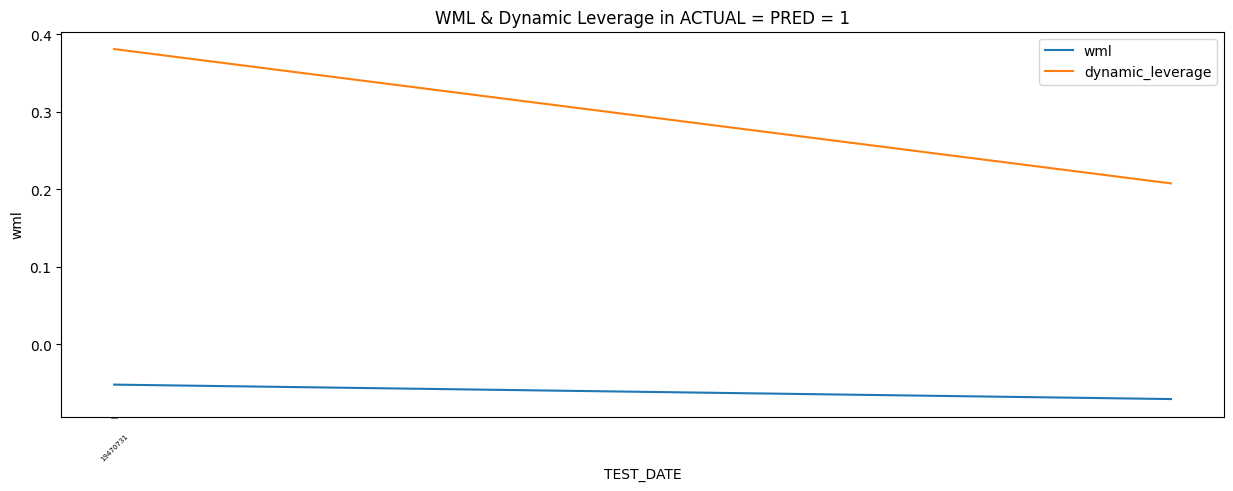

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,2.0,-0.061433,0.000174,0.013179,-0.070753,-0.070566,-0.066093,-0.061433,-0.056774,-0.052301,-0.052114


,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_leverage,2.0,0.294192,0.015023,0.122568,0.207523,0.209257,0.250857,0.294192,0.337526,0.379127,0.38086



--------------------------------------------------------------------------------


ACTUAL = PRED = 0



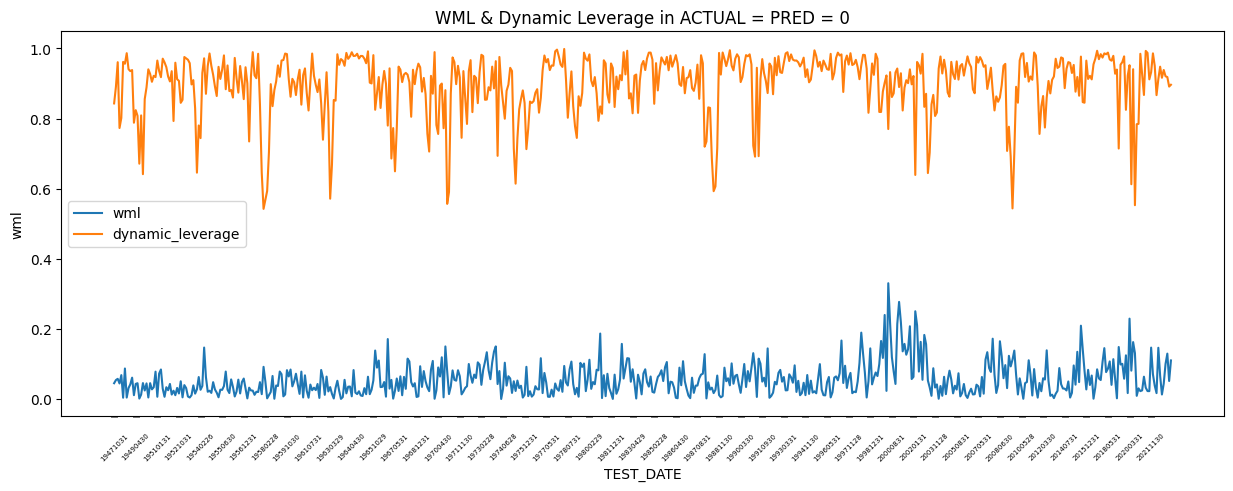

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,588.0,0.055305,0.002198,0.046879,0.000007,0.000687,0.021416,0.04509,0.077301,0.21716,0.330163


,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_leverage,588.0,0.899228,0.007565,0.08698,0.542267,0.587821,0.868997,0.922405,0.960212,0.992875,0.998358



--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



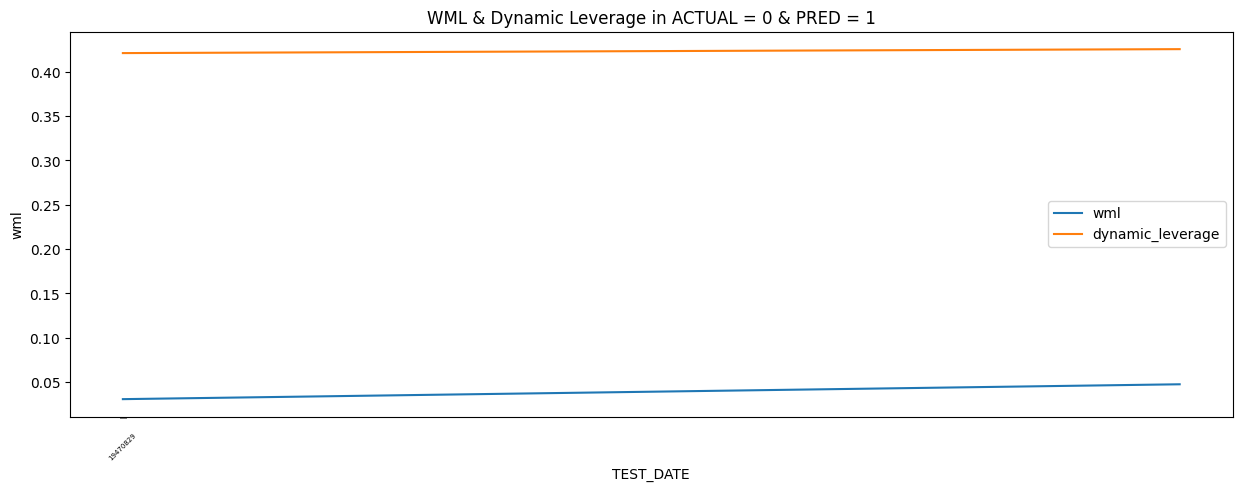

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,2.0,0.039023,0.000141,0.011863,0.030634,0.030802,0.034828,0.039023,0.043217,0.047243,0.047411


,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_leverage,2.0,0.423419,0.00001,0.003151,0.421191,0.421235,0.422305,0.423419,0.424533,0.425602,0.425646



--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



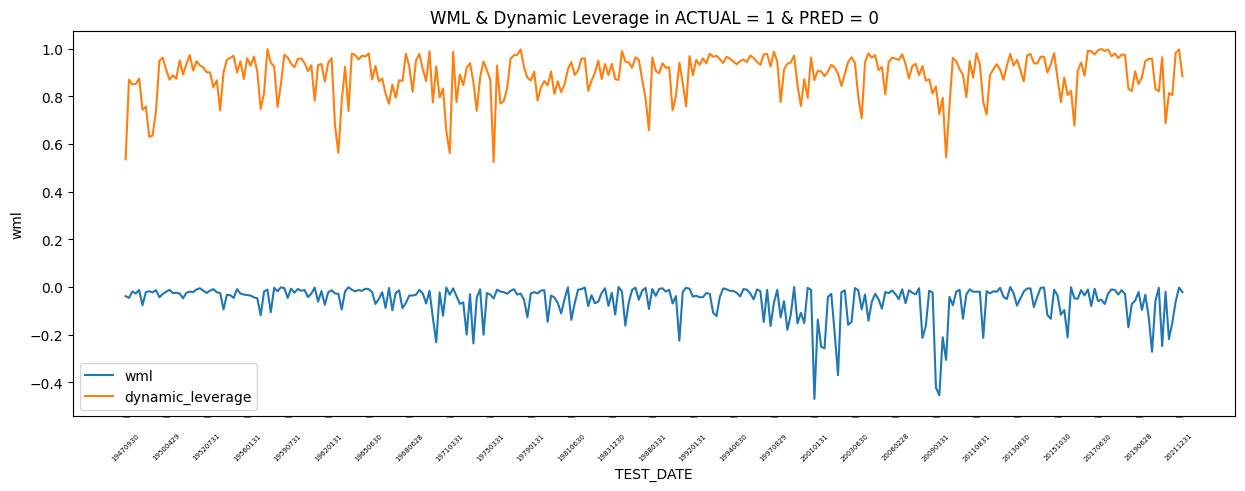

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
wml,314.0,-0.056278,0.005106,0.071457,-0.469903,-0.361714,-0.06784,-0.028501,-0.014546,-0.000972,-0.000132


,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_leverage,314.0,0.891212,0.007591,0.087126,0.524136,0.561645,0.860415,0.917115,0.954038,0.996294,0.998442


In [77]:
plot_predict_result(Fixed_PCA_Result)


Top 5 dyn_mom



,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,dynamic_leverage,anomaly_score,Actual_POS_WML,static_leverage,cum_return
TEST_DATE,,,,,,,,,
20000229,19800229,20000131,0.330163,0.254214,0.769964,0.769964,0,0,32863.643175
20010228,19810227,20010131,0.276912,0.246380,0.889741,0.889741,0,0,29353.554213
20200331,20000331,20200228,0.229130,0.218144,0.952055,0.952055,0,0,65342.856306
19991231,19791231,19991130,0.239571,0.216101,0.902032,0.902032,0,0,25655.171757
20150731,19950731,20150630,0.209036,0.204146,0.976608,0.976608,0,0,41976.763956



Bottom 5 dyn_mom



,TRAIN_START_DATE,TRAIN_END_DATE,wml,dynamic_momentum,dynamic_leverage,anomaly_score,Actual_POS_WML,static_leverage,cum_return
TEST_DATE,,,,,,,,,
20010131,19810130,20001229,-0.469903,-0.407669,0.867560,0.867560,1,0,23550.855842
20090331,19890331,20090227,-0.422400,-0.355233,0.840986,0.840986,1,0,50301.728075
20021129,19821130,20021031,-0.370041,-0.331045,0.894619,0.894619,1,0,42178.709943
20090430,19890428,20090331,-0.454349,-0.329231,0.724621,0.724621,1,0,33740.505219
20200430,20000428,20200331,-0.271971,-0.260373,0.957357,0.957357,1,0,48329.062948


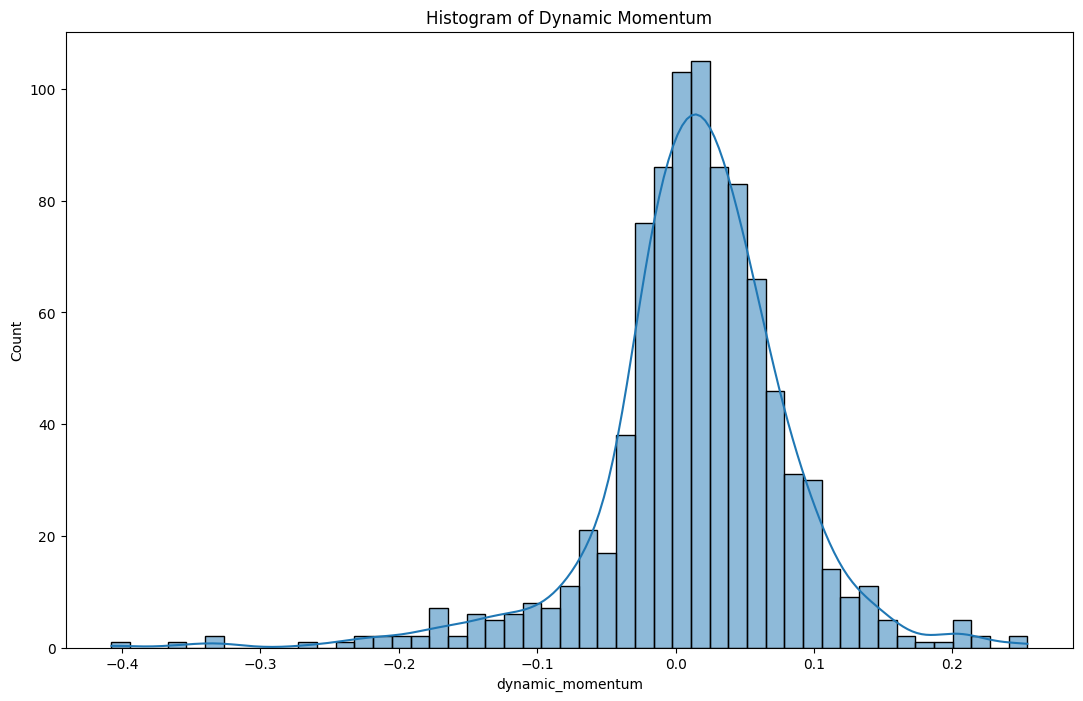

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_momentum,906.0,0.015006,0.004623,0.06799,-0.407669,-0.211934,-0.014644,0.01683,0.051088,0.194213,0.254214


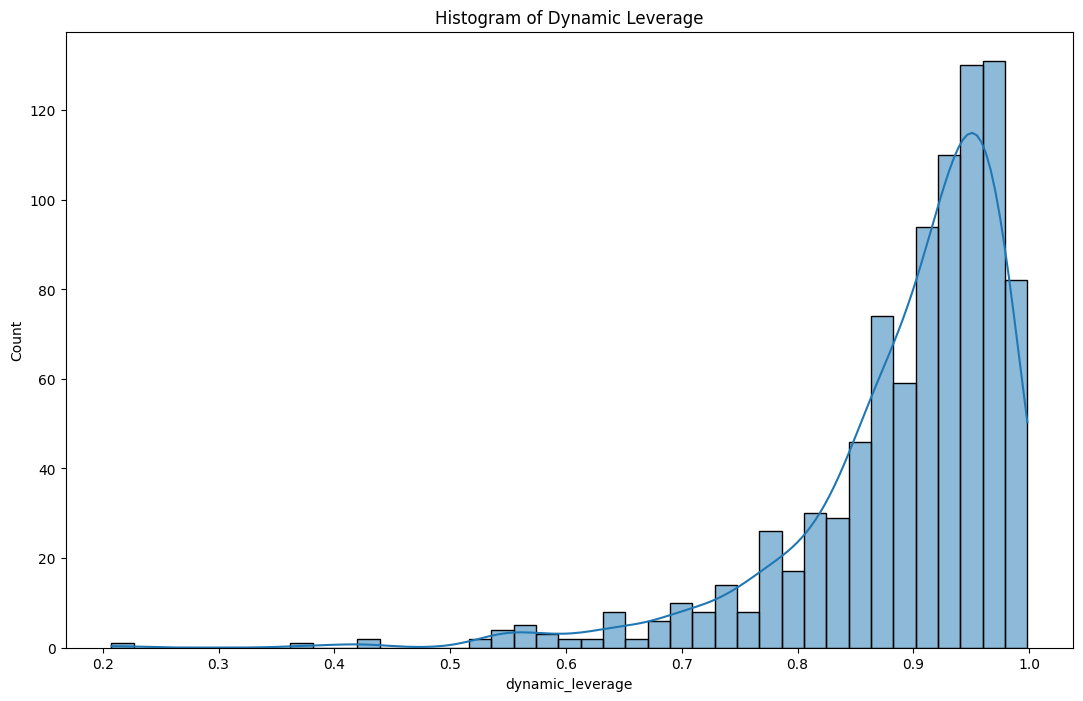

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
dynamic_leverage,906.0,0.894064,0.008854,0.094096,0.207523,0.552882,0.863592,0.921256,0.957729,0.993286,0.998442


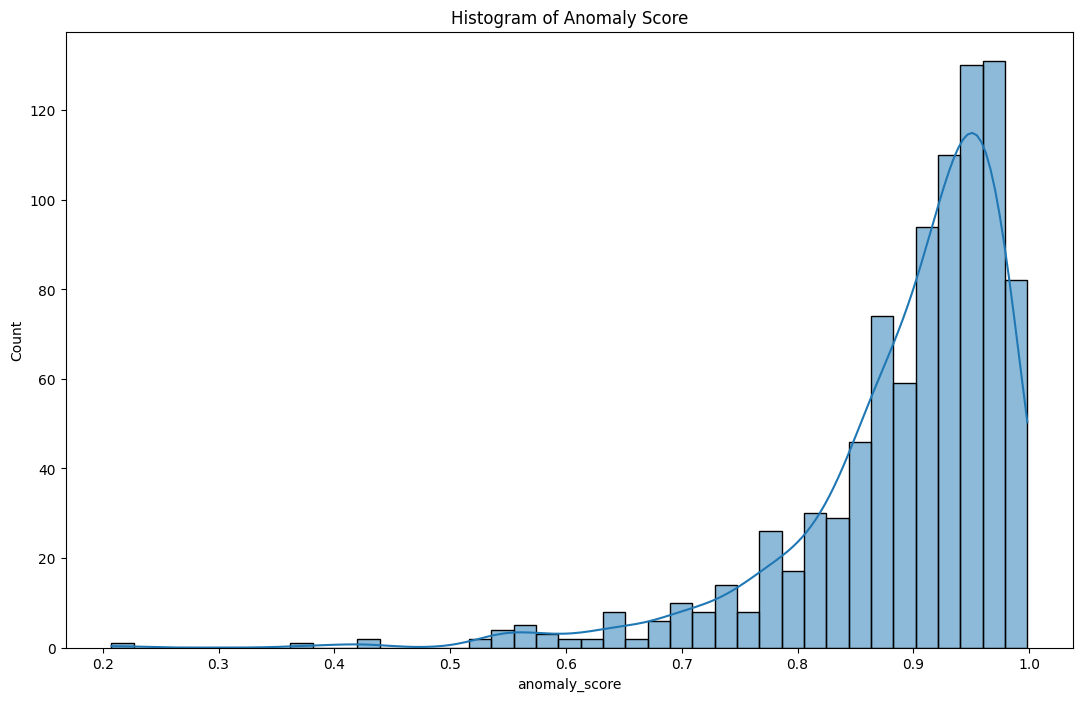

,count,mean,var,std,min,1%,25%,50%,75%,99%,max
anomaly_score,906.0,0.894064,0.008854,0.094096,0.207523,0.552882,0.863592,0.921256,0.957729,0.993286,0.998442


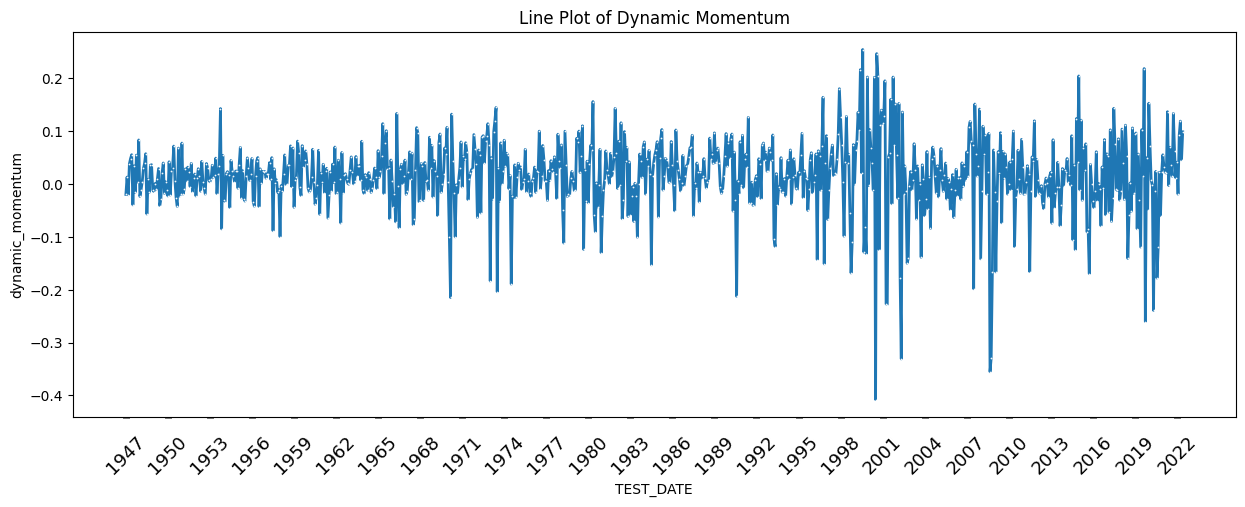

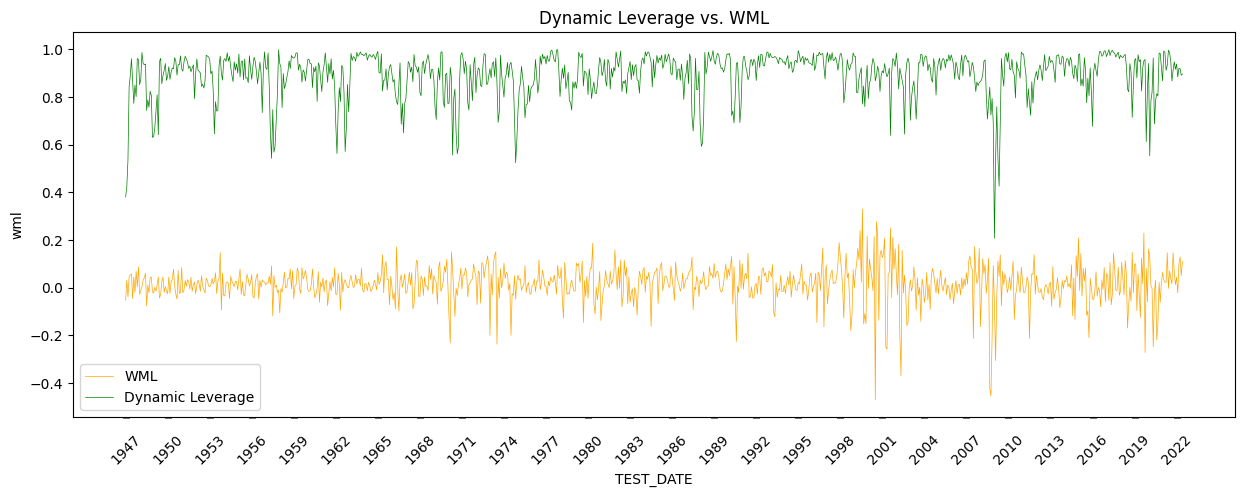

In [78]:
plot_dynamic_momentum(Fixed_PCA_Result)